__Table of Contents__

1. Introduction

2. Dataset and feature selection

3. Exploratory data analysis

4. Modeling

5. Diagnostics and Predictive checks

6. Potential improvements and challenges

7. Conclusion



# Introduction

In this project, we apply Bayesian linear regression on King County housing dataset to model housing prices. For this task, we experiment two different models - _pooled_ and _hierarchical intercept_. For the hierarchical intercept model we use zip codes as levels to distinguish groups in the data. We will show the reasoning behind the this decision in the expalanatory data analysis part. Taken together, we found out that that the _hierarchical intercept_ model outperformed _pooled_ model, which was expected when we saw the visualizations of expolantory data analysis. 

__NOTE__ We have transferred visualizations functions and stan code into appendix to make this notebook more readable.

In [138]:
!pip install arviz
!pip install pystan
import arviz as az
import numpy as np
import pystan
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
import warnings
warnings.simplefilter('ignore')
import seaborn as sns
import time
df = pd.read_csv('kc_house_data.csv')

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Dataset and feature selection

## Dataset

The dataset contains 21 different variables and 21613 observations. Below is the description of each variable. 

| variable | description  | 
|---|---|
| __Id__  | Unique ID for each home sold  |
| __Date__ | Date of the home sale  | 
| __Price__  | Price of each home sold | 
| __Bedrooms__ | Number of bedrooms | 
| __Bathrooms__ | Number of bathrooms, where .5 accounts for a room with a toilet but no shower  | 
| __Sqft_living__  | Square footage of the apartments interior  |
| __Sqft_lot__  | Square footage of the land space  |
| __Floors__  | Number of floors | 
| __Waterfront__ | A dummy variable for whether the apartment was overlooking the waterfront or not | 
| __View__ | An index from 0 to 4 of how good the view of the property was | 
| __Condition__  | An index from 1 to 5 on the condition of the apartment  |
| __Grade__ | An index from 1 to 13, higher value indicates high quality level of construction and design  |
| __Sqft_above__  | The square footage of interior housing space that is above ground level |
| __Sqft_basement__  | The square footage of the interior housing space that is below ground | 
| __Yr_built__ | The year the house was initially built  | 
| __Yr_renovated__ | The year of the house's last renovation  | 
| __Zipcode__  | What zipcode area the house is in  |
| __Lat__  | Latitude  |
| __Long__  | Longitude |
| __Sqft_living15__  | The square footage of interior housing living space for the nearest 15 neighbors  |
| __Sqft_lot15__  | The square footage of the land lots of the nearest 15 neighbors |

## Feature selection

We approached this task in an iterative manner. In our first iteration, we used most of the continuous variables in our Stan model. This, as it turned out, took ages to run due to high number of sampling. As we realized that we didn't have enough computational power to run the models, we decided to cut the number of variables with feature selection. Feature selection was done by using RandomForestRegressor's feature importance attribute. Based on this analysis we end up having two predictors - `grade` and `sqft_living` - to predict house prices.

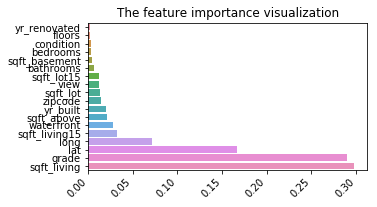

In [139]:
model = RandomForestRegressor()
df_predictors = df[['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15']]
model.fit(df_predictors, df['price'])
series = pd.Series(model.feature_importances_, index=df_predictors.columns).sort_values()
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(series.values, series.index, ax=ax)
fig.autofmt_xdate(rotation=45)
plt.title('The feature importance visualization')
plt.show()

In [140]:
df = df[['price', 'zipcode', 'lat', 'long', 'sqft_living', 'grade']]

# Exploratory data analysis

Reassuringly, the below correlation matrix shows that variables`sqft_living` and `grade` are highly correlated with the dependent variable `price`. This further supports our decision to use the mentioned variables in our Stan models.

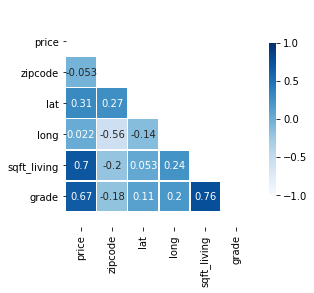

In [141]:
corr_matrix(df)

Note: *The first batch of plots use data as it is. The second batch of plots use log-tansformed data.*


These plots show that the size of a house is positively correlated with the price of a house. The scatterplots are colorcoded based on variable `grade`, which clearly illustrates dispersion between different grades. In some sense, one  could use variable `grade` as the level for the hierarchical model, but as we mentioned in the beginning we will use zip codes for this purpose.

As we can see, these distributions have heavy tails suggesting that we can proceed with one of two ways:
1. Use students t-distribution in Stan to to obtain robust regression
2. Apply log-transformation to address non-normality and use normal distribution in Stan to obtain robust regression

Again, recall that this notebook has been built iteratively. At first, we used the first option (students t-distribution) to create the Stan models. This, however, proved to deliver bad results. Consequently, we decided to proceed with the latter option (normal distribution).

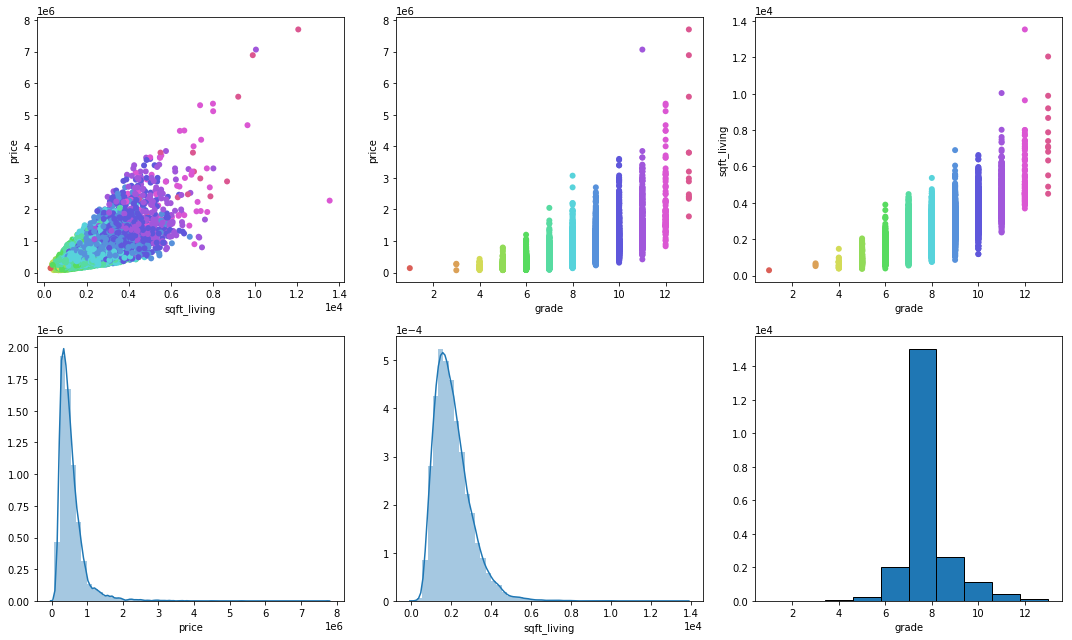

In [142]:
pairwise_plot(df)

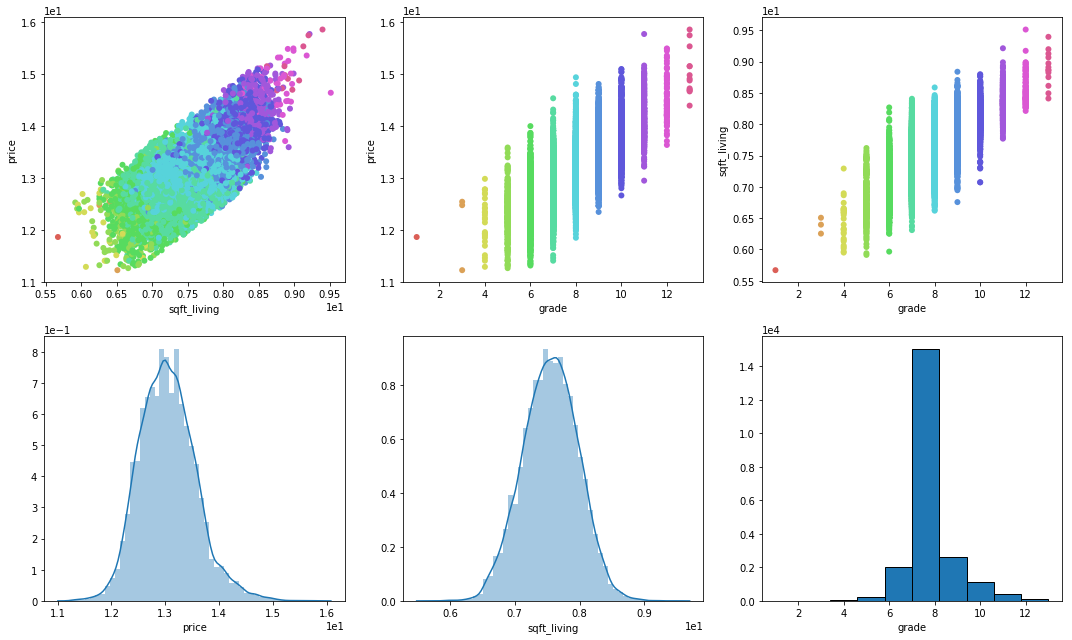

In [143]:
df_log = np.log(df[['price', 'sqft_living']].copy())
df_log['grade'] = df['grade'] 
df_log['long'] = df['long'] 
df_log['lat'] = df['lat'] 
df_log['zipcode'] = df['zipcode'] 
pairwise_plot(df_log)

These heatmaps illustrate the differences of price, size and grade across different areas (lognitude and latitude). Basically these values were calculated by grouping the dataset by zip codes and then taking the median of these values (median because it is more robust than mean). The boxplots are telling us similar information in a different way.

These visualizations validates our use of zipcodes as a levels in hierarchical intercept models. We can already say from this exploratory analysis that hierarchical intercept model will likely to outperform the pooled model in terms of predictive performance. This is because pooled model is not flexible enough.

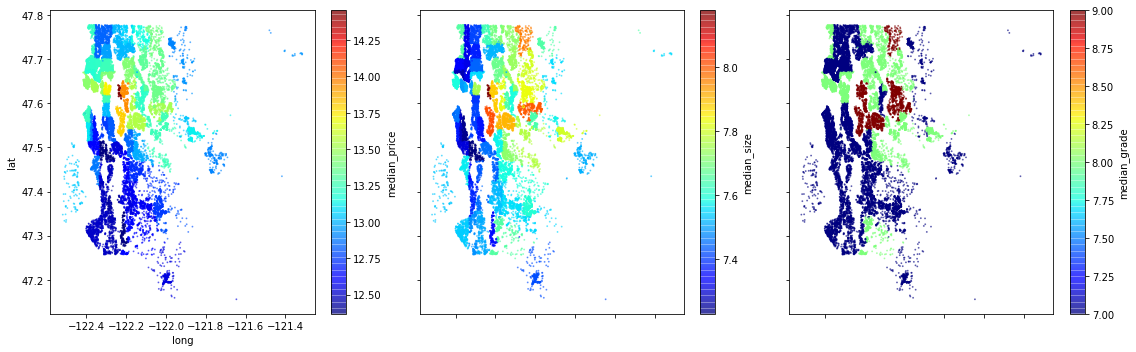

In [144]:
heatmaps(df_log)

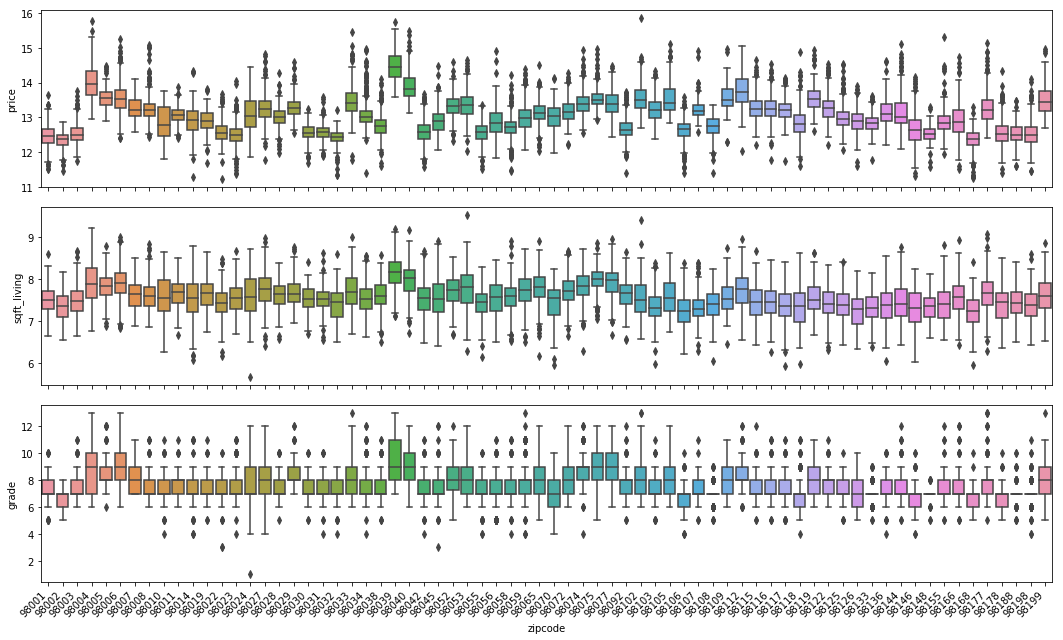

In [145]:
boxplots(df_log)

# Modeling


## Likelihood

Essentially, the choice for our likelihood distribution was two-fold: for one, the target label `price` is continuous and secondly, it has a heavily dispersed distribution. A natural continuation could have been to use students-t distribution, however, we learned that it was difficult to model and that it did not converge well. Therefore, we applied log-transformation for the variable `price` and proceeded with normal distribution.


## Choice of priors

The choice of prior is a really difficult task. It is not a trivial task to analyse proper prior for the coefficients. If our model was as follows (only intercept model):

$$ price_i = \alpha $$

then the choice of prior would be really easy. However, since this was not the case for us, we took upon ourselves to research [real home prices at King County](https://www.redfin.com/county/118/WA/King-County/housing-market) and considered the following factors when deciding our prios:

1. We found out that the average home prices in King County hover around $610K. 

2. In line with our log-transformed target label, we also took logarithms of $610K. The log of 610K is ~13. 

3. We assume that our predictors `size` and `grade` have positive impact on the price. Hence, we decided to lower the $\mu$ for the intercept prior - $\alpha$. So instead of using 13 we used 10. The $\mu$ for $\beta_1$ and $\beta_2$ are 0.5 and 0.1, respectively. 

$$\alpha \sim N(10, 10)$$

$$\beta_1 \sim N(0.5, 1)$$

$$\beta_2 \sim N(0.1, 1)$$

In these steps, we follow Andrew Gelman, one of the worlds foremost Bayesian statistician, in adjusting our [weakly informative priors](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations). Based on this, the scale parameter for the model is:

$$\sigma \sim Half-cauchy(0, 2.5)$$

## Models

In the introduction we mentioned the two different models which we are going to use, _pooled_ and _hierarchical intercept_.
The main goal here is to use two predictors `size` and `grade` to predict house prices.

### Pooled

In pooled model we do not have any groups or levels. In other words, we treat that all the zip codes are same. 

$$log(price)_i \sim N(a + b_1log(size)_i+b_2grade_i, \sigma)$$

### Hierarchical intercept

The hierarchical intercept model allows the intercept vary by group (or levels). The main motivation to use hierarchical intercept model can be seen from our exploratory data analysis. There is clear differences between each zipcode.  

$$log(price)_i \sim N(a_{j[i]} + b_1log(size)_i+b_2grade_i, \sigma)$$

The j indicates the zipcode. In our dataset we had 70 different zip codes, i.e. $j = 1,...,70$

## Fitting the models

For computational reasons, we had to split the dataset, since the warm-up process was extremely slow. We used the test dataset to check how well the models generalize on new data.

In [156]:
df_log['zipID'] = 0
for i, zipcode in enumerate(df.zipcode.unique()):
    df_log.loc[df_log.zipcode == zipcode, 'zipID'] = i+1
    
# Split data in training and test set and center the predictor variables
df_log['sqft_living'] = df_log.iloc[:,1:2].apply(lambda x: x-x.mean())
df_log['grade'] = df_log.iloc[:,2:3].apply(lambda x: x-x.mean())
train, test, _, _ = train_test_split(df_log, df_log.zipID, test_size=0.5, random_state=12)

### Fit pooled model

In [158]:
pooled_data = {'N': len(train),
               'y': train.price.values,
               'x1': train.sqft_living.values,
               'x2': train.grade.values,
               'N_test': len(test),
               'x1_test': test.sqft_living.values,
               'x2_test': test.grade.values}

#### How Stan model is run

__NOTE__ The stan code can be seen from the appendix!

We have saved the stan code as file and run it by calling the filename __pooled_weakly.stan__. 
- 4 chains
- 1500 iteraions for each chain
- 50% for warm-up 

In [159]:
start_time = time.time()
pooled_fit = pystan.stan(file='pooled_weakly.stan' , data=pooled_data, chains=4, iter=1500)
print('It took {:.2f} seconds to run this model'.format(time.time()-start_time))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_69557a722ce77c5669fa1ebec5cb54b1 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


It took 773.29 seconds to run this model


#### LOO, $P_{eff}$ and K-values

In [160]:
az_pooled = az.from_pystan(pooled_fit, log_likelihood="log_lik")
pooled_loo = az.loo(az_pooled, scale='log', pointwise = True)
pooled_loo

Computed from 3000 by 10806 log-likelihood matrix

         Estimate       SE
elpd_loo -4090.46    72.15
p_loo        4.16        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     10806  100.0%
 (0.5, 0.7]   (ok)           0    0.0%
   (0.7, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%

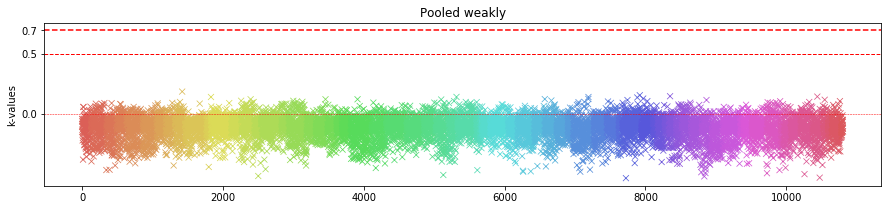

In [161]:
k_values_viz(pooled_loo, train, 'Pooled weakly')

#### HMC diagnostics

In [162]:
start_time = time.time()
pystan.diagnostics.check_hmc_diagnostics(pooled_fit, verbose=3)
print('It took {:.2f} seconds to run this diagnostics'.format(time.time()-start_time))

INFO:pystan:n_eff / iter looks reasonable for all parameters
INFO:pystan:Rhat looks reasonable for all parameters
INFO:pystan:No divergent transitions found.
INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit
INFO:pystan:Chain 1: E-BFMI (= 1.13) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 2: E-BFMI (= 1.08) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 3: E-BFMI (= 1.16) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 4: E-BFMI (= 0.953) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior


It took 618.70 seconds to run this diagnostics


### Fit hierarchical intercept model

In [163]:
intercept_data = {'N': len(train),
                  'y': train.price.values,
                  'x1': train.sqft_living.values,
                  'x2': train.grade.values,
                  'zipID': train.zipID.values.astype(int),
                  'numzipID': len(train.zipID.unique()),
                  'N_test':len(test),
                  'x1_test': test.sqft_living.values,
                  'x2_test': test.grade.values,
                  'zipID_test': test.zipID.values.astype(int)}

#### How Stan model is run

__NOTE__ The stan code can be seen from the appendix!

We have saved the stan code as file and run it by calling the filename __intercept_weakly1.stan__. 
- 4 chains
- 2500 iteraions for each chain
- 50% for warm-up 
- We had problems with autocorrelation and ($n_{eff}$) and max treedepth. Hence, we set max_treedepth from 10 to 15. 

In [164]:
start_time = time.time()
intercept_fit = pystan.stan(file='intercept_weakly1.stan', data=intercept_data, chains=4, iter=2500, control={'max_treedepth':15}, seed=42)
print('It took {:.2f} seconds to run this model'.format(time.time()-start_time))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_af806b8a7aeeaca23e33d683531ce7cc NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


It took 2497.98 seconds to run this model


#### LOO, $P_{eff}$ and K-values

In [165]:
az_intercept = az.from_pystan(intercept_fit, log_likelihood="log_lik")
intercept_loo = az.loo(az_intercept, scale='log', pointwise = True)
intercept_loo

Computed from 5000 by 10806 log-likelihood matrix

         Estimate       SE
elpd_loo  1518.69   119.47
p_loo       76.22        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     10806  100.0%
 (0.5, 0.7]   (ok)           0    0.0%
   (0.7, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%

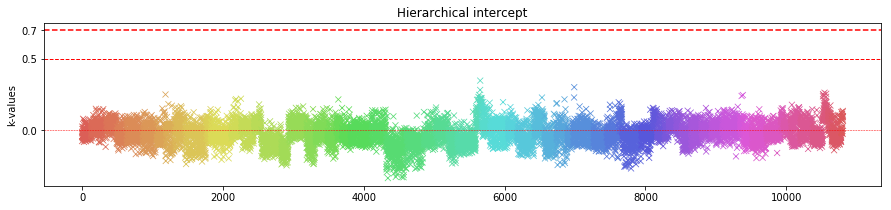

In [166]:
k_values_viz(intercept_loo, train, 'Hierarchical intercept')

#### HMC diagnostics

In [167]:
start_time = time.time()
pystan.diagnostics.check_hmc_diagnostics(intercept_fit, verbose=3)
print('It took {:.2f} seconds to run this diagnostics'.format(time.time()-start_time))

INFO:pystan:n_eff / iter looks reasonable for all parameters
INFO:pystan:Rhat looks reasonable for all parameters
INFO:pystan:No divergent transitions found.
INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit
INFO:pystan:Chain 1: E-BFMI (= 1) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 2: E-BFMI (= 1.03) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 3: E-BFMI (= 0.922) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 4: E-BFMI (= 1.04) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior


It took 1945.34 seconds to run this diagnostics


In [171]:
print(intercept_fit)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Diagnostics and predictive checks


## Summary of fits

||Pooled|Hierarchical intercept|
|---|---|---|
|$LOO_{CV}$|-4090.26 |1518.47|
|$P_{eff}$|4.04|76.47|
|$P$|4|75|
|$K-Values$|OK |OK|
|$N_{eff}$|OK |OK|
|$\widehat{R}$| OK |OK|
|$Divergence$|OK |OK|
|$Treedepth$|OK|OK|
|$Energy$|OK |OK|

$LOO_{CV}$: We are using logarithmic scale with loo as our information criteria. Based on this setup, higher information criteria indicates higher out-of-sample predictive fit. I.e. the higher the loo value the better. In that sense, hierarchical intercept model outperforms pooled model.

$P_{eff}$: The effective number of parameters should be smaller than or similar to the total number of parameters in the model. In both models this seems to be case. It is likely that our models are well-specified. 

$K-Values$: Since all the k-values are below 0.7 (and 0.5), we can say that the results are reliable, that is, the model is likely to be OK.

$N_{eff}$: Since MCMC samples are dependent it is also important to check effective sample size. In our case, we didn't have any values where $\frac{N_{eff}}{iterations} < 0.001$. Therefore we can say taht there is no autocorrelation. In this sense, our model is OK. 

$\widehat{R}$: Here, we want to check whether the chains have the same mean. In our case, $\widehat{R}$ values for the parameters were below 1.1. This indicates that everything is "OK" and our chains have likely converged.

$Divergence$: We didn't have divergencies in our fit. This means that our estimators are not biased. If we had divergencies it would indicate that the Markov chain did not completely explore the posterior -> MCMC estimators would be biased.

$Tree-depth$: We didn't have any iterations saturated the maximum tree depth of 10 (pooled) or 15 (hierarchical intercept). The tree-depth only affects efficiency. In the case of hierarchical intercept we had to increase the maximum tree depth from default 10 to 15. This helped to get reasonable $N_{eff}$ values for our parameters.

$Energy$: THE E-BFMI values for each chain exceeds threshold of 0.2. This indicated no pathological behavior. 

## Parameters

We have plotted the boxplots of the intercepts of the fits (hierarchical intercept model) and the logarithmic prices of each area. This validates our use of zipcodes as a levels in our hieararhical intercept model. We can see the intercepts follows the logarithmic prices at some level.

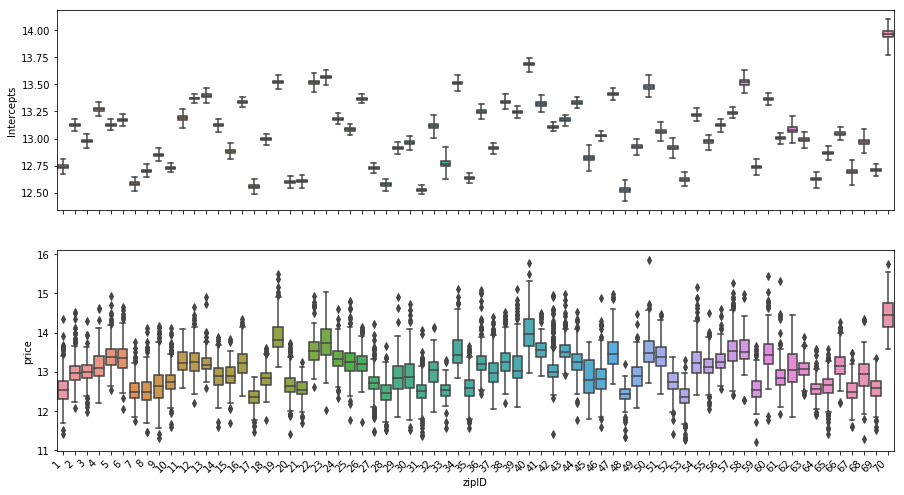

In [168]:
price_box(df_log, intercept_fit)

## Posterior predictive checks

Here we visualize how well we are able to replicate the data. Both models seems to replicate the original data fairly well. The hierarchical intercept model replicates the data slightly better than pooled model. This can be seen from the peakness of the pooled model's replicated data. 

ValueError: No parameter y_reps

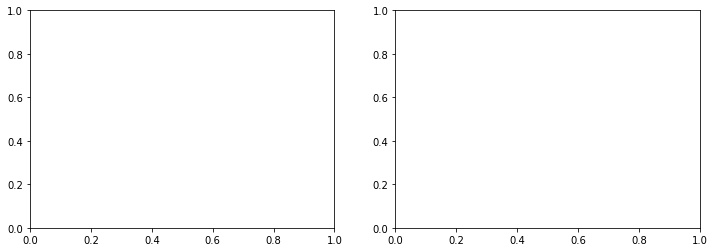

In [169]:
predictive_check_1(pooled_fit, intercept_fit)

Based on the following visualization we can see that both of the models have similar means and deviations with respect to true mean and true deviation. 

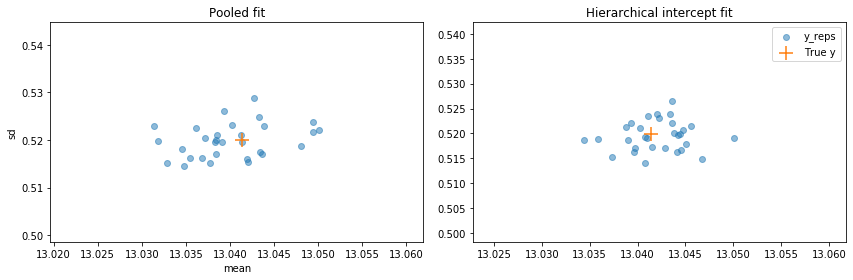

In [72]:
predictive_check_2(pooled_fit, intercept_fit)

The following plot is basically similar to previous plot. However, we are looking at all the iterations and we are focusing only on mean. Again, from this plot we can conclude that both of our models are performing fairly well.

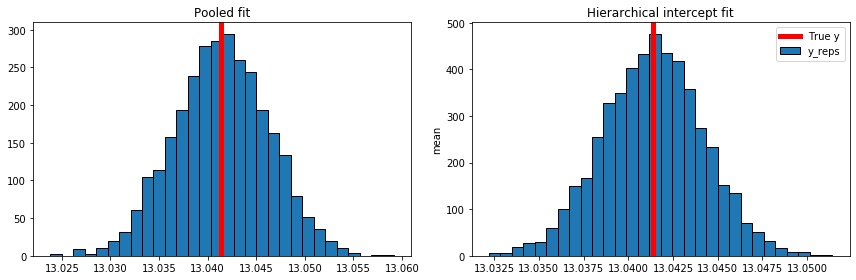

In [73]:
predictive_check_3(pooled_fit, intercept_fit)

In this visualization we wanted to see the predictive performance. Here we tested how well our model performs to unseen data. In the perfect model the scatterplot would be close to red line. However, it seems that both of our models are slightly underestimating the prices. That is, our model tends to output lower value when in reality the true price is higher. 

There is clear difference between the pooled model and hierarchical intercept model. The hierarchical generalizes much better on unseen data than pooled model.

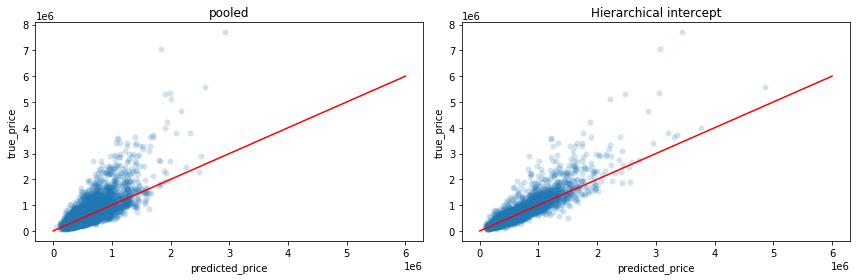

In [74]:
true_vs_predict(pooled_fit, intercept_fit)

# Potential improvements and challenges

Overall, we see that there are four points for improvement.

1. In this project we use pooled and hierarchical intercept model. However, we could further extend the model by making also the $\beta$ - coefficients hierarchical. This could potentially improve the model and its predictive performance. 

2. We used random forest regressor to choose the variables for this model. However, we could do more sophisticated feature selection and analyse how many features we would need to include in the model.

3. We personally had problems for fitting the Student-t likelihood. However, Student-t regression is in fact more robust than normal regression. For example, with more sophisticated feature selection one might be able to fit Student-t regression.

4. We didn't try this and hence we are not sure but using non-linear model __might__ perform better since our model slightly underestimates the expensive houses. 

# Conclusions 

Put it together, this study shows that the two independent variables - __size__ and __grade__ - fit fairly well on the data. Reassuringly, we are able to determine that both of our models converged well with $\widehat{R}$ values well below 1.1. Moreover, we can also conclude that our model is likely to be reliable since pareto $k-values$ are below 0.7 (and below 0.5). Based on the information criteria - $loo_{cv}$ - the hierarchical intercept model outperforms the pooled model. This didn't come as a suprise since as pointed out in exploratory data analysis the median price, apartment size and grade are all neatly clustered along zip codes. However, although our models fit the data fairly well, both of the models underestimate housing prices.

# Appendix

## Pooled weakly informative<a id='section_id'></a>
```c++
data {
        int <lower=0> N; 
        vector[N] y;  
        vector[N] x1; 
        vector[N] x2; 
        int <lower=0> N_test; 
        vector[N_test] x1_test;
        vector[N_test] x2_test; 
}
parameters {
        real alpha; 
        vector[2] beta;
        real <lower=0> sigma; 
}
model {
        y ~ normal(alpha + beta[1]*x1 + beta[2]*x2, sigma);
        alpha ~ normal(10, 10);
        beta[1] ~ normal(0.5, 1);
        beta[2] ~ normal(0.1, 1);
        sigma ~ cauchy(0, 2.5);
}
generated quantities {
        vector[N] log_lik;
        vector[N_test] y_preds;
        vector[N] y_reps;
        for (i in 1:N_test){
            y_preds[i] = normal_rng(alpha + beta[1]*x1_test[i] + beta[2]*x2_test[i], sigma);
        }
        for (i in 1:N){
            log_lik[i] = normal_lpdf(y[i] | alpha + beta[1]*x1[i] + beta[2]*x2[i], sigma);
            y_reps[i] = normal_rng(alpha + beta[1]*x1[i] + beta[2]*x2[i], sigma);
        }
}
```

## Hierarchical intercept 

```c++
data {
        int <lower=0> N;
        vector[N] y;  
        vector[N] x1; 
        vector[N] x2; 
        int zipID[N]; 
        int numzipID; 
        int <lower=0> N_test; 
        vector[N_test] x1_test; 
        vector[N_test] x2_test; 
        int zipID_test[N_test]; 
}
parameters {
        real alpha[numzipID];   
        real beta[2]; 
        real <lower=0> sigma;   
        real alpha_p;
        real <lower=0> alpha_sigma_p;
}    
model {
        // priors
        alpha ~ normal(alpha_p, alpha_sigma_p);
        beta[1] ~ normal(0.5, 1);
        beta[2] ~ normal(0.1, 1);
        sigma ~ cauchy(0, 2.5);
        // hyperpriors
        alpha_p ~ normal(10, 10);
        alpha_sigma_p ~ cauchy(0, 2.5);
        for (i in 1:N) {
            y[i] ~ normal(alpha[zipID[i]] + beta[1]*x1[i] + beta[2]*x2[i], sigma);
        }
}  
generated quantities {
        vector[N] log_lik;
        vector[N] y_reps;
        vector[N_test] y_preds;
        for (i in 1:N){
            log_lik[i] = normal_lpdf(y[i] | alpha[zipID[i]] + beta[1]*x1[i] + beta[2]*x2[i], sigma);
            y_reps[i] = normal_rng(alpha[zipID[i]] + beta[1]*x1[i] + beta[2]*x2[i], sigma);
        }
        for (i in 1:N_test){
            y_preds[i] = normal_rng(alpha[zipID_test[i]] + beta[1]*x1_test[i] + beta[2]*x2_test[i], sigma);
        }
}
```

## Confusion matrix

In [1]:
def corr_matrix(df):
    fig, ax = plt.subplots(figsize = (6,4))
    corr = df.corr()
    mask = np.zeros_like(corr, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(corr, mask = mask, square = True, cbar = True, annot = True, 
                linewidths = 0.5, cbar_kws = {'shrink':0.7, 'ticks':[-1, -.5, 0, 0.5, 1]},
                vmin = -1, vmax = 1, annot_kws = {'size':10}, cmap = 'Blues', ax=ax)
    b, t = plt.ylim()
    b += 0.5 
    t -= 0.5
    plt.ylim(b, t)
    plt.show()

## Pairwise plot

In [2]:
def pairwise_plot(df):
    fig, axes = plt.subplots(2, 3, figsize=(15, 9))

    sns.scatterplot(x='sqft_living', y='price', hue='grade', data=df, palette=sns.color_palette('hls', 12), ax=axes[0, 0], legend=False, linewidth=0)
    sns.scatterplot(x='grade', y='price', hue='grade', data=df, palette=sns.color_palette('hls', 12), ax=axes[0, 1], legend=False, linewidth=0)
    sns.scatterplot(x='grade', y='sqft_living', hue='grade', data=df, palette=sns.color_palette('hls', 12), ax=axes[0, 2], legend=False, linewidth=0)
    sns.distplot(df.price, ax=axes[1, 0])
    sns.distplot(df.sqft_living, ax=axes[1, 1])
    axes[1, 2].hist(df.grade, edgecolor='black')
    axes[1, 2].set_xlabel('grade')
    axes[0, 0].ticklabel_format(axis='both', style='sci', scilimits=(10, 0))
    axes[0, 1].ticklabel_format(axis='y', style='sci', scilimits=(10, 0))
    axes[0, 2].ticklabel_format(axis='y', style='sci', scilimits=(10, 0))
    axes[1, 0].ticklabel_format(axis='both', style='sci', scilimits=(10, 0))
    axes[1, 1].ticklabel_format(axis='both', style='sci', scilimits=(10, 0))
    axes[1, 2].ticklabel_format(axis='y', style='sci', scilimits=(10, 0))
    plt.tight_layout()
    plt.show()

## Heatmaps

In [3]:
def heatmaps(df):
    median_df = df_log[['zipcode', 'long', 'lat']].copy()
    median_df['median_price'] = 0
    median_df['median_size'] = 0
    median_df['median_grade'] = 0
    for zipcode in df.zipcode.unique():
        median_df.loc[df.zipcode == zipcode, 'median_price'] = df_log.loc[df.zipcode == zipcode, 'price'].median()
        median_df.loc[df.zipcode == zipcode, 'median_size'] = df_log.loc[df.zipcode == zipcode, 'sqft_living'].median()
        median_df.loc[df.zipcode == zipcode, 'median_grade'] = df_log.loc[df.zipcode == zipcode, 'grade'].median()
    var = ['median_price', 'median_size', 'median_grade']
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    median_df.plot(kind='scatter', x='long', y='lat', c=var[0], cmap=plt.get_cmap('jet'), alpha=0.5, s=0.8, ax=axes[0])
    median_df.plot(kind='scatter', x='long', y='lat', c=var[1], cmap=plt.get_cmap('jet'), alpha=0.5, s=0.8, ax=axes[1])
    median_df.plot(kind='scatter', x='long', y='lat', c=var[2], cmap=plt.get_cmap('jet'), alpha=0.5, s=0.8, ax=axes[2])

    plt.setp(axes[1].get_xticklabels(), visible=False)
    plt.setp(axes[2].get_xticklabels(), visible=False)
    plt.setp(axes[1].get_yticklabels(), visible=False)
    plt.setp(axes[2].get_yticklabels(), visible=False)
    axes[1].xaxis.label.set_visible(False)
    axes[2].xaxis.label.set_visible(False)
    axes[1].yaxis.label.set_visible(False)
    axes[2].yaxis.label.set_visible(False)
    plt.tight_layout()
    plt.show()

## Boxplots

In [4]:
def boxplots(df):
    fig, ax = plt.subplots(3, 1, figsize=(15, 9))
    sns.boxplot(x='zipcode', y='price', data=df, ax=ax[0])
    sns.boxplot(x='zipcode', y='sqft_living', data=df, ax=ax[1])
    sns.boxplot(x='zipcode', y='grade', data=df, ax=ax[2])
    fig.autofmt_xdate(rotation=45)
    plt.tight_layout()
    plt.show()

## K-values 

In [5]:
def k_values_viz(loo, df, title):
    result = pd.DataFrame({'zipID': df.zipID, 'zipcode':df.zipcode, 'k-values':loo.pareto_k.values})
    result = result.sort_values('zipID')
    fig, axes = plt.subplots(figsize=(15,3))
    sns.scatterplot(x=range(len(df)), y='k-values', hue='zipID', data=result, palette=sns.color_palette('hls', 70), marker='x',
                    ax=axes, legend=False)
    axes.axhline(y=0.7, linestyle='--', c='red')
    axes.axhline(y=0.5, linestyle='--', linewidth=1, c='red')
    axes.axhline(y=0, linestyle='--', linewidth=0.5, c='red')
    axes.set_yticks([0, 0.5, 0.7])
    axes.set_title(title)
    plt.show()
    

## Price vs intercept boxplot

In [6]:
def price_box(df, fit):
    fig, ax = plt.subplots(2, 1, figsize=(15, 9))
    sns.boxplot(data=intercept_fit['alpha'], whis=np.inf, ax=ax[0])
    ax[0].set_ylabel('Intercepts')
    sns.boxplot(x='zipID', y='price', data=df, ax=ax[1])
    fig.autofmt_xdate(rotation=45)
    plt.show()

## Predictive check 1

In [7]:
def predictive_check_1(pooled_fit, intercept_fit):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    for y_pred in pooled_fit['y_reps'][:200]:
        sns.kdeplot(y_pred, c='blue', alpha=0.01, ax=axes[0])
    sns.kdeplot(test.price, c='black', ax=axes[0])

    for y_pred in intercept_fit['y_reps'][:200]:
        sns.kdeplot(y_pred, c='blue', alpha=0.01, ax=axes[1])
    sns.kdeplot(test.price, c='black', ax=axes[1])
    axes[0].set_title('Pooled fit')
    axes[1].set_title('Hierarchical intercept fit')
    axes[0].set_ylim(0, 0.85)
    axes[1].set_ylim(0, 0.85)
    plt.tight_layout()
    plt.show()

## Predictive check 2

In [8]:
def predictive_check_2(pooled_fit, intercept_fit):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].scatter(pooled_fit['y_reps'][:30].mean(axis=1), pooled_fit['y_reps'][:30].std(axis=1), alpha=0.5, label='y_reps')
    axes[0].scatter(train.price.mean(), train.price.std(), marker='+', s=200, label='True y')
    axes[1].scatter(intercept_fit['y_reps'][:30].mean(axis=1), intercept_fit['y_reps'][:30].std(axis=1), alpha=0.5, label='y_reps')
    axes[1].scatter(train.price.mean(), train.price.std(), marker='+', s=200, label='True y')
    axes[0].set_title('Pooled fit')
    axes[1].set_title('Hierarchical intercept fit')
    axes[0].set_xlabel('mean')
    axes[0].set_ylabel('sd')
    plt.legend()
    plt.tight_layout()
    plt.show()

## Predictive check 3

In [9]:
def predictive_check_3(pooled_fit, intercept_fit):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].hist(pooled_fit['y_reps'].mean(axis=1), label='y_reps', edgecolor='black', bins=30)
    axes[0].axvline(train.price.mean(), linewidth=5, color='red', label='True y')
    axes[1].hist(intercept_fit['y_reps'].mean(axis=1), label='y_reps', edgecolor='black', bins=30)
    axes[1].axvline(train.price.mean(), linewidth=5, color='red', label='True y')
    axes[0].set_title('Pooled fit')
    axes[1].set_title('Hierarchical intercept fit')
    axes[1].set_ylabel('mean')
    plt.legend()
    plt.tight_layout()
    plt.show()

## True vs predicted

In [10]:
def true_vs_predict(pooled_fit, intercept_fit):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    title = ['pooled', 'Hierarchical intercept']
    sns.scatterplot(np.exp(pooled_fit['y_preds'].mean(axis=0)), np.exp(test.price), ax=axes[0], linewidth=0, alpha=0.2)
    sns.scatterplot(np.exp(intercept_fit['y_preds'].mean(axis=0)), np.exp(test.price), ax=axes[1], linewidth=0, alpha=0.2)
    for i in range (0, 2):
        sns.lineplot(x=np.linspace(0, 6000000), y=np.linspace(0, 6000000), ax=axes[i], color='red')
        axes[i].set_xlabel('predicted_price')
        axes[i].set_ylabel('true_price')
    axes[0].set_title(title[0])
    axes[1].set_title(title[1])
    axes[0].ticklabel_format(axis='both', style='sci', scilimits=(10, 0))
    axes[1].ticklabel_format(axis='both', style='sci', scilimits=(10, 0))
    plt.tight_layout()
    plt.show()
    
    # exp pooled fit(ypreds + error^2/2)